## Random forest; 2018

In [2]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, cross_val_score, LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

## Load data

In [3]:
current_dir = os.getcwd()
path = os.path.join(current_dir, 'data/clean', "merged_dataset_1.csv")
df = pd.read_csv(path)

In [4]:
df = df[df["Year"] == 2018].copy()

In [5]:
cols_to_drop = [
    'Well_ID', 'BRO-ID', 'geometry', 'Filter', 'Date', 'distance_m', 'Year',
    'Unnamed: 0'
]

df = df.drop(columns=cols_to_drop, errors="ignore")

In [6]:
# remove outliers
top_nitrate_outliers = list(df["Nitrate"].sort_values()[-3:].index)
top_nitrate_outliers
df = df.drop(top_nitrate_outliers)
len(df)

51

In [7]:
df = df.dropna()
len(df)

50

In [8]:
df['log_Nitrate'] = np.log1p(df['Nitrate']) 

In [9]:
X = df[['avg_depth_m', 'Population', 'HGRnaam', 'Landuse_Code',
       'avg_temp_mean', 'avg_precip_sum', 'lon', 'lat',
       'Elevation_m']]
y = df["log_Nitrate"]

In [10]:
categorical = ["Landuse_Code", "HGRnaam"]
numerical = [col for col in X.columns if col not in categorical]

In [11]:
preprocessor = ColumnTransformer(transformers=[
    ("num", SimpleImputer(strategy="mean"), numerical),
    ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical)
])

# Build pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [12]:
from sklearn.ensemble import RandomForestRegressor
from mapie.regression import MapieRegressor

# Define base regressor
base_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Wrap with Mapie for quantile regression
mapie = MapieRegressor(estimator=base_model, method="quantile", alpha=0.1)
mapie.fit(X_train, y_train)

# Predict with prediction intervals
y_pred, y_interval = mapie.predict(X_test, return_prediction_intervals=True)

# y_interval[:, 0] = lower bound, y_interval[:, 1] = upper bound


ImportError: cannot import name 'MapieRegressor' from 'mapie.regression' (/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/mapie/regression/__init__.py)

In [1996]:
# Fit the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
print("R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R²: 0.19341299258037337
MSE: 0.5233400923408781


In [ ]:

model = RandomForestQuantileRegressor(random_state=42)
model.fit(X_train, y_train)
model.predict(X_test, quantile=0.5) 

In [1997]:
param_grid = {
    'regressor__n_estimators': [50, 70, 99, 100, 101, 200],
    'regressor__max_depth': [5, 10, 11, None],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2],
    'regressor__max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best R² score (CV):", grid_search.best_score_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best parameters: {'regressor__max_depth': 5, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 50}
Best R² score (CV): -0.11119359498727048


In [1920]:
df.dtypes

Nitrate                                                                           float64
avg_depth_m                                                                       float64
Population                                                                        float64
HGRnaam                                                                            object
Landuse_Code                                                                      float64
avg_temp_mean                                                                     float64
avg_precip_sum                                                                    float64
Total Livestock                                                                   float64
Excretion during grazing (million kg)                                               int64
Municipal waste (1000 tonnes)/Total municipal waste (1 000 tonnes)                  int64
Nitrogen losses in housing and storages/Total nitrogen losses (N) (million kg)      int64
Use of liv

## Simple data preprocessing

In [1921]:
df['HGRnaam'] = df['HGRnaam'].str.lower()     # make lower case

# label encode HGRnaam
le = LabelEncoder()
df['HGRnaam'] = le.fit_transform(df['HGRnaam'])

# Convert Landuse_Code to int (after handling NaNs if any)
df['Landuse_Code'] = df['Landuse_Code'].fillna(-1).astype(int)  # Use -1 or any other value for missing

In [1922]:
df.dtypes

Nitrate                                                                           float64
avg_depth_m                                                                       float64
Population                                                                        float64
HGRnaam                                                                             int64
Landuse_Code                                                                        int64
avg_temp_mean                                                                     float64
avg_precip_sum                                                                    float64
Total Livestock                                                                   float64
Excretion during grazing (million kg)                                               int64
Municipal waste (1000 tonnes)/Total municipal waste (1 000 tonnes)                  int64
Nitrogen losses in housing and storages/Total nitrogen losses (N) (million kg)      int64
Use of liv

### Convert to categories

In [1923]:
# df['HGRnaam'] = df['HGRnaam'].astype("category")
# df['Landuse_Code'] = df['Landuse_Code'].astype("category")

In [1924]:
# df.dtypes

## Identify outliers

<Axes: >

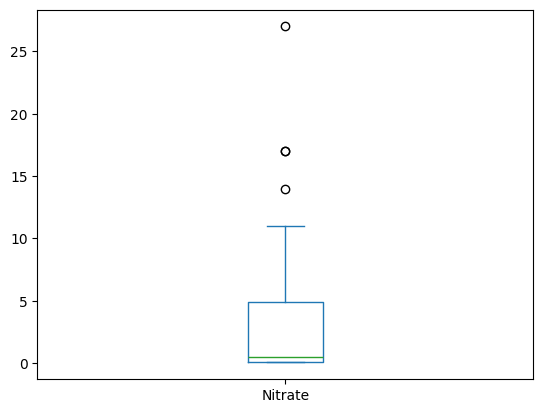

In [1925]:
df[["Nitrate"]].plot(kind = "box")

In [1926]:
# remove outliers
top_nitrate_outliers = list(df["Nitrate"].sort_values()[-3:].index)
top_nitrate_outliers
df = df.drop(top_nitrate_outliers)
len(df)

[78, 72, 56]

51

In [1928]:
df = df.dropna()

In [1929]:
len(df)

50

## Generate train/test split

In [1930]:
df['log_Nitrate'] = np.log1p(df['Nitrate']) 

In [1931]:
X = df[['avg_depth_m', 'Population', 'HGRnaam', 'Landuse_Code',
       'avg_temp_mean', 'avg_precip_sum', 'lon', 'lat',
       'Elevation_m']]
y = df["log_Nitrate"]

In [1932]:
categorical_cols = X.select_dtypes(include=["category", "object"]).columns.tolist()

In [1933]:
categorical_cols

[]

## Build a model

In [1934]:
categorical_cols = ['HGRnaam', 'Landuse_Code']
numeric_cols = [col for col in X.columns if col not in categorical_cols]

ordinal_encoder = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

In [1935]:
preprocessor = ColumnTransformer([
    ("cat", ordinal_encoder, categorical_cols)
])

In [1936]:
rf = RandomForestRegressor(random_state=3)

pipeline = Pipeline([
    ("pre", preprocessor),
    ("regressor", rf)
])

In [1937]:
# param_grid = {
#     "regressor__n_estimators": [35, 40, 45, 50],
#     "regressor__max_depth": [6, 7, 8],
#     "regressor__min_samples_split": [2, 4],
#     "regressor__min_samples_leaf": [1],
#     "regressor__max_features": [0.8, 0.5, 0.3],  # NOTE The default value max_features=1.0 uses n_features rather than n_features / 3. The latter was originally suggested in [1], whereas the former was more recently justified empirically in [2].
#     # "regressor__min_impurity_decrease": [0.0, 0.01, 0.05],
#     "regressor__max_samples": [None, 0.9, 0.8] # how many data points we use for one tree

# }

In [1952]:
param_grid = {
    'regressor__n_estimators': [35, 40, 45, 50],
    'regressor__max_depth': [5, 10, 11, None],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [None],
    'regressor__max_features': [3]
}

In [1953]:
cv = KFold(n_splits=5, shuffle=True, random_state=12)

grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring="r2", n_jobs=-1)
grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
print("Best CV R^2 score:", grid_search.best_score_)

ValueError: 
All the 160 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 98, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'min_samples_leaf' parameter of RandomForestRegressor must be an int in the range [1, inf) or a float in the range (0.0, 1.0). Got None instead.


In [1940]:
model = RandomForestRegressor(n_estimators=50, max_features=3, max_samples=None, oob_score=True)
rf = model.fit(X, y)
print(f"OOB score: {rf.oob_score_}")

OOB score: 0.1522847027164531


In [1956]:
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
import numpy as np

# Define columns
categorical_cols = ['HGRnaam', 'Landuse_Code']
numeric_cols = [col for col in X.columns if col not in categorical_cols]

# Preprocessor
preprocessor = ColumnTransformer([
    ("cat", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
    ("num", SimpleImputer(strategy='mean'), numeric_cols)
])

# Best model from earlier grid search
rf = RandomForestRegressor(
    n_estimators=50,
    max_depth=5,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features='sqrt',
    random_state=3
)

pipeline = Pipeline([
    ("pre", preprocessor),
    ("regressor", rf)
])

# Evaluate using LOOCV (will take time)
loo = LeaveOneOut()
scores = cross_val_score(pipeline, X, y, cv=loo, scoring="r2")

print("LOOCV R² mean:", np.mean(scores))


/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMe

LOOCV R² mean: nan


/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMe

In [1941]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [1942]:
model = RandomForestRegressor(n_estimators=50, max_features=3, max_samples=None, oob_score=True)
rf = model.fit(X_train, y_train)
print(f"OOB score: {rf.oob_score_}")

OOB score: 0.3055169585013867


In [1943]:
rf.feature_importances_

array([0.15953192, 0.07923388, 0.08263066, 0.0724484 , 0.07771499,
       0.05860304, 0.09197167, 0.10069342, 0.27717202])

<Axes: >

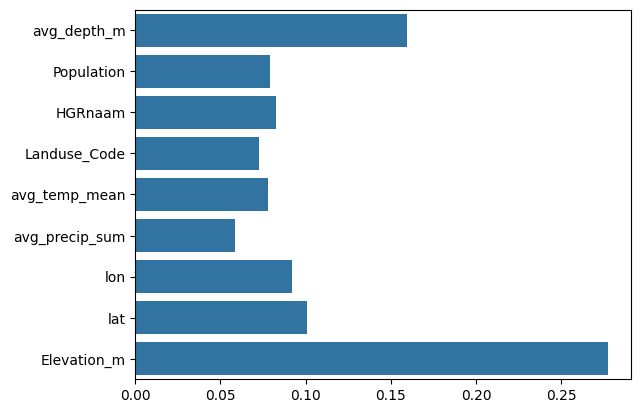

In [1944]:
sns.barplot(x = rf.feature_importances_, y = rf.feature_names_in_)

In [1945]:
pred_nitrate = rf.predict(X_test)

mae = mean_absolute_error(y_true=np.exp(y_test), y_pred=pred_nitrate)
print(f"MAE: {mae}")

mse = mean_squared_error(y_true=np.exp(y_test), y_pred=pred_nitrate)
print(f"MSE: {mse}")

MAE: 1.7511234798625133
MSE: 7.058633255321999


<Axes: xlabel='log_Nitrate', ylabel='log_Nitrate'>

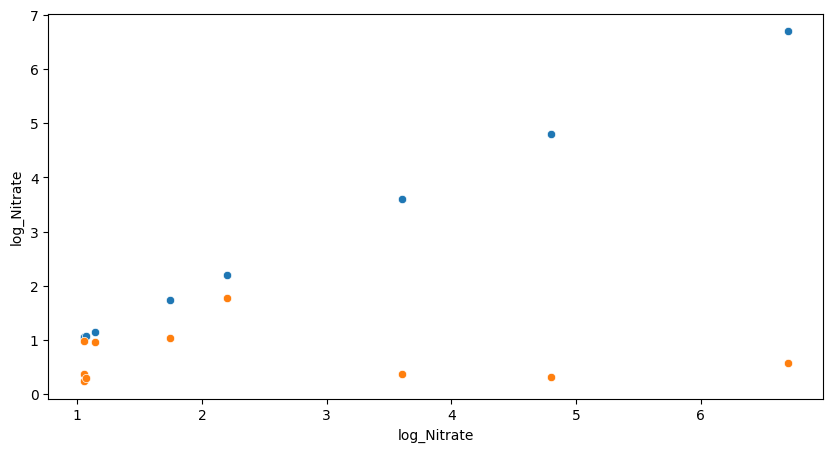

In [1946]:
fix, ax = plt.subplots(figsize= (10,5))

sns.scatterplot(x = np.exp(y_test), y = np.exp(y_test), ax = ax)
sns.scatterplot(x = np.exp(y_test), y = pred_nitrate, ax = ax)

## Preprocessing + Model pipeline

In [1947]:
# preprocessor = ColumnTransformer([
#     ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
# ], remainder="passthrough")

# rf = RandomForestRegressor(random_state=42)

# cv = KFold(n_splits=5, shuffle=True, random_state=12)

In [1948]:
# pipeline = Pipeline([
#     ("preprocess", preprocessor),
#     ("regressor", rf)
# ])

In [1949]:
# param_grid = {
#     "regressor__n_estimators": [30, 50, 60],
#     "regressor__max_depth": [None, 4, 5, 6],
#     "regressor__min_samples_split": [2, 4, 6, 8, 10],
#     "regressor__min_samples_leaf": [1, 2, 3],
#     "regressor__max_features": [0.5, 0.3],  # NOTE The default value max_features=1.0 uses n_features rather than n_features / 3. The latter was originally suggested in [1], whereas the former was more recently justified empirically in [2].
#     # "regressor__min_impurity_decrease": [0.0, 0.01, 0.05],
#     "regressor__max_samples": [None, 0.8] # how many data points we use for one tree

# }

In [1950]:
# grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring="r2", n_jobs=-1)
# grid_search.fit(X, y)

# print("Best parameters:", grid_search.best_params_)
# print("Best CV R^2 score:", grid_search.best_score_)

In [1951]:
# best_model = grid_search.best_estimator_
# loocv = LeaveOneOut()
# scores = cross_val_score(best_model, X, y, cv=loocv, scoring="r2")
# print("LOOCV R² mean score:", scores.mean())